# Part 3: Trip Distribution 
    Choose approach to conduct trip distribution step for the future transportation demand, prepare data for this step and implement it. 

In [ ]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.formula.api import logit
import statsmodels.api as sm
import scipy as sp
import geopandas as gpd
from shapely import wkt

In [4]:
#### Store the url string that hosts our .csv files 
#### Copy data files to the 2022CMS folder that should be in the same folder as this notebook
urlday = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Day_2022.csv"
urlhhl = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Household_2022.csv"
urlper = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Person_2022.csv"
urlzon = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Survey_Zones.csv"
urltrp = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Trip_2022.csv"
urlveh = "C:\\Users\\Administrator\\Downloads\\project_data\\Citywide_Mobility_Survey_-_Vehicle_2022.csv"

#### Read the .csv file using `pandas` libriary and store it as a `pandas` Data Frame
dday = pd.read_csv(urlday)
dhhl = pd.read_csv(urlhhl)
dper = pd.read_csv(urlper)
dzon = pd.read_csv(urlzon)
dtrp = pd.read_csv(urltrp)
dveh = pd.read_csv(urlveh)

#### Finally, let's make sure that all columns are displayed
pd.set_option('display.max_columns', None)

## Step I: Creating distance table

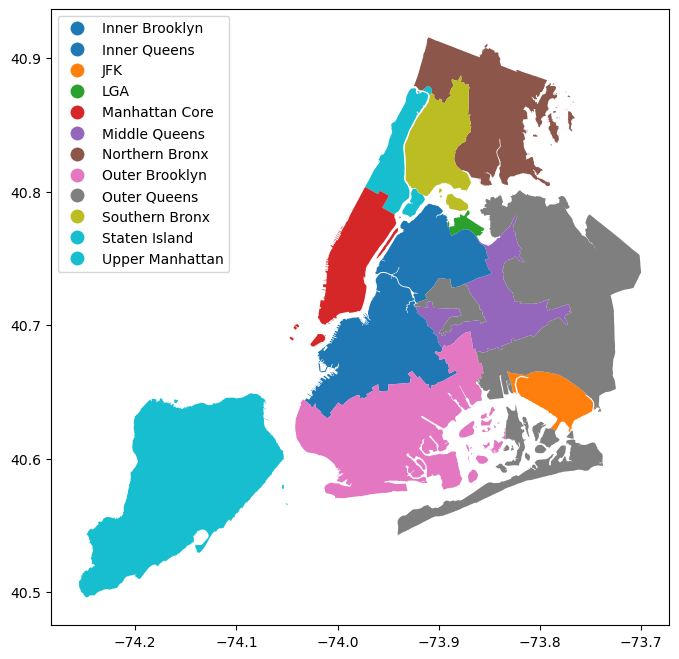

In [25]:
dzon["geometry"] = dzon["Shape"].apply(wkt.loads)

gdf = gpd.GeoDataFrame(dzon, geometry="geometry", crs="EPSG:4326")
gdf.plot(column="CMS Zone", legend=True, legend_kwds={'loc':'upper left'}, figsize=(8, 8))
plt.show()

In [38]:
gdf_proj = gdf.to_crs(epsg=2263)
gdf_proj['centroid'] = gdf_proj.geometry.centroid

n_zones = 12
distance_matrix = pd.DataFrame(index=gdf_proj['CMS Zone'], columns=gdf_proj['CMS Zone'], dtype=float)

for i in range(n_zones):
    for j in range(n_zones):
        distance_matrix.iloc[i,j] = gdf_proj['centroid'].iloc[i].distance(gdf_proj['centroid'].iloc[j])

display(distance_matrix)

CMS Zone,Middle Queens,Inner Brooklyn,Northern Bronx,Outer Brooklyn,LGA,Inner Queens,JFK,Outer Queens,Upper Manhattan,Southern Bronx,Manhattan Core,Staten Island
CMS Zone,,,,,,,,,,,,
Middle Queens,0.000000,33778.822792,53624.235587,43119.503202,23175.727443,21735.485969,29474.852073,15017.296390,47571.297144,46215.737628,40565.241694,98571.318470
Inner Brooklyn,33778.822792,0.000000,72286.858428,22210.095852,41230.525963,29980.704343,49294.109603,46070.231004,52116.949021,58217.677231,26223.586712,65357.821054
Northern Bronx,53624.235587,72286.858428,0.000000,91010.699817,32530.422135,42506.461903,80216.268498,60936.418120,28370.233584,16806.285504,54734.434630,132505.628694
Outer Brooklyn,43119.503202,22210.095852,91010.699817,0.000000,58635.511747,48791.249515,43866.619348,49753.516124,73535.426386,78403.108379,48420.427379,60818.332613
LGA,23175.727443,41230.525963,32530.422135,58635.511747,0.000000,11676.673859,52318.051724,34922.728030,25554.492426,23051.319462,31525.588846,104850.693288
Inner Queens,21735.485969,29980.704343,42506.461903,48791.249515,11676.673859,0.000000,50664.596500,36263.248138,27483.705228,29825.594160,21683.871083,93174.047656
JFK,29474.852073,49294.109603,80216.268498,43866.619348,52318.051724,50664.596500,0.000000,19441.804910,77046.060942,75135.316484,66360.357101,104668.657606
Outer Queens,15017.296390,46070.231004,60936.418120,49753.516124,34922.728030,36263.248138,19441.804910,0.000000,60392.398206,57003.027250,55577.031350,108768.918321
Upper Manhattan,47571.297144,52116.949021,28370.233584,73535.426386,25554.492426,27483.705228,77046.060942,60392.398206,0.000000,11848.903321,29185.739619,106547.092627


## Trip Distribution Results Discussion

    How future distribution is different compared to trip distribution in 2022? Provide at least 1 graph to support your discussion.
